### Importing Dependencies

In [36]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Reading the dataset in parquet format

In [2]:
df = pd.read_parquet('customer_churn_large_dataset_optimized.parquet')

Displaying the dataset

In [3]:
df.head()

CustomerID        Name  Age  Gender     Location  \
0           1  Customer_1   63    Male  Los Angeles   
1           2  Customer_2   62  Female     New York   
2           3  Customer_3   24  Female  Los Angeles   
3           4  Customer_4   36  Female        Miami   
4           5  Customer_5   46  Female        Miami   

   Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
0                          17         73.36             236  False  
1                           1         48.76             172  False  
2                           5         85.47             460  False  
3                           3         97.94             297   True  
4                          19         58.14             266  False

In [4]:
df.tail()

CustomerID             Name  Age  Gender     Location  \
99995       99996   Customer_99996   33    Male      Houston   
99996       99997   Customer_99997   62  Female     New York   
99997       99998   Customer_99998   64    Male      Chicago   
99998       99999   Customer_99999   51  Female     New York   
99999      100000  Customer_100000   27  Female  Los Angeles   

       Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
99995                          23         55.13             226   True  
99996                          19         61.65             351  False  
99997                          17         96.11             251   True  
99998                          20         49.25             434   True  
99999                          19         76.57             173   True

Checking info of the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   CustomerID                  100000 non-null  int64   
 1   Name                        100000 non-null  object  
 2   Age                         100000 non-null  int8    
 3   Gender                      100000 non-null  category
 4   Location                    100000 non-null  category
 5   Subscription_Length_Months  100000 non-null  int8    
 6   Monthly_Bill                100000 non-null  float64 
 7   Total_Usage_GB              100000 non-null  int16   
 8   Churn                       100000 non-null  bool    
dtypes: bool(1), category(2), float64(1), int16(1), int64(1), int8(2), object(1)
memory usage: 3.0+ MB


Checking for missing values

In [6]:
df.isnull().sum()

CustomerID                    0
Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

Describing the dataset

In [7]:
df.describe()

CustomerID            Age  Subscription_Length_Months  \
count  100000.000000  100000.000000               100000.000000   
mean    50000.500000      44.027020                   12.490100   
std     28867.657797      15.280283                    6.926461   
min         1.000000      18.000000                    1.000000   
25%     25000.750000      31.000000                    6.000000   
50%     50000.500000      44.000000                   12.000000   
75%     75000.250000      57.000000                   19.000000   
max    100000.000000      70.000000                   24.000000   

        Monthly_Bill  Total_Usage_GB  
count  100000.000000   100000.000000  
mean       65.053197      274.393650  
std        20.230696      130.463063  
min        30.000000       50.000000  
25%        47.540000      161.000000  
50%        65.010000      274.000000  
75%        82.640000      387.000000  
max       100.000000      500.000000

<Axes: xlabel='Churn', ylabel='count'>

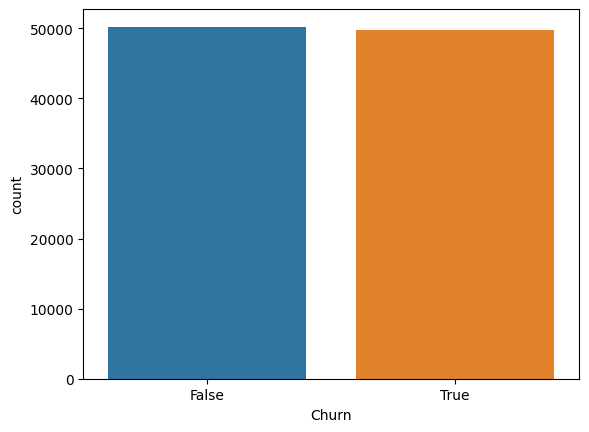

In [8]:
# PLotting the distribution of the target variable
sns.countplot(x='Churn', data=df)

The target variable is balanced in the dataset, so no need to use Stratified KFold.

### Plotting the correlation matrix

In [9]:
corr = df.corr()

C:\Users\Cypher\AppData\Local\Temp\ipykernel_19712\658818363.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

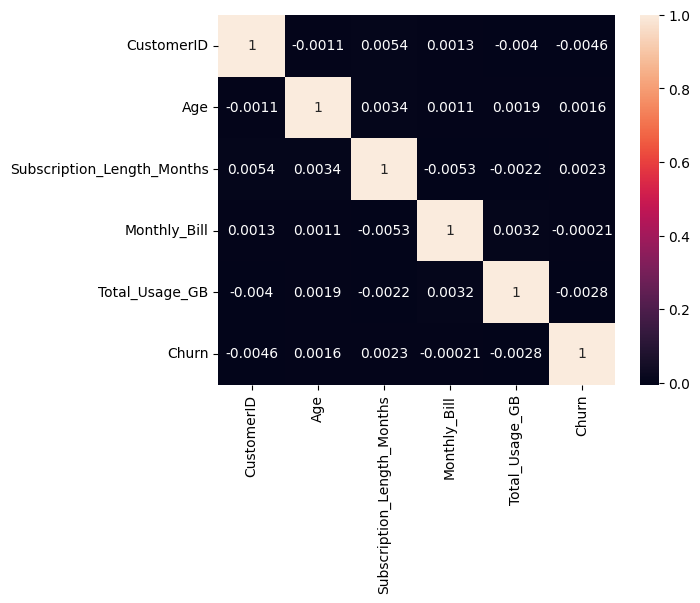

In [10]:
sns.heatmap(corr, annot=True)

This shows a very weak relationship among all the columns and a non-linear relationship between the target variable and the independent variables.

### Checking for Outliers

In [11]:
# List of numerical columns to check for outliers
numerical_columns = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']

In [12]:
# Plotting box plots for each numerical column
for column in numerical_columns:
    px.box(df, y=column).show()

The graphs ploted are interactive and hovering over them will show more information.
There are no outliers in the dataset.

### Encoding the categorical variables

In [13]:
le = LabelEncoder()

In [14]:
df['Gender'] = le.fit_transform(df['Gender'])
df['Location'] = le.fit_transform(df['Location'])
df['Churn'] = le.fit_transform(df['Churn'])

In [15]:
df.head()

CustomerID        Name  Age  Gender  Location  Subscription_Length_Months  \
0           1  Customer_1   63       1         2                          17   
1           2  Customer_2   62       0         4                           1   
2           3  Customer_3   24       0         2                           5   
3           4  Customer_4   36       0         3                           3   
4           5  Customer_5   46       0         3                          19   

   Monthly_Bill  Total_Usage_GB  Churn  
0         73.36             236      0  
1         48.76             172      0  
2         85.47             460      0  
3         97.94             297      1  
4         58.14             266      0

### Splitting the dataset into train and test

In [30]:
X = df.drop(['Churn', 'CustomerID', 'Name'], axis=1)
y = df['Churn']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature engineering
Based on the given data, we can create two new features:
1. Average Usage per Month: This will be the total usage divided by the subscription length in months. It will give us an idea of how much a user utilizes the service on average every month.
2. Bill to Usage Ratio: This feature represents the amount billed for every GB used. It can give insights into whether the user is getting value for their money.

In [32]:
X_train['Avg_Usage_per_Month'] = X_train['Total_Usage_GB'] / X_train['Subscription_Length_Months']
X_test['Avg_Usage_per_Month'] = X_test['Total_Usage_GB'] / X_test['Subscription_Length_Months']

X_train['Bill_to_Usage_Ratio'] = X_train['Monthly_Bill'] / X_train['Total_Usage_GB']
X_test['Bill_to_Usage_Ratio'] = X_test['Monthly_Bill'] / X_test['Total_Usage_GB']

X_train['Age_to_Usage_Ratio'] = X_train['Age'] / X_train['Total_Usage_GB']
X_test['Age_to_Usage_Ratio'] = X_test['Age'] / X_test['Total_Usage_GB'] 

In [33]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model training 

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [39]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred.round())

0.5003

In [34]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
accuracy_score(y_test, rf.predict(X_test))

0.50235

____

In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

accuracy_score(y_test, lr.predict(X_test))

0.5002

Model Evaluation

In [40]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [41]:
y_pred = lgbm.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.5039


In [ ]:
import catboost as cb

cat = cb.CatBoostClassifier(verbose=False)

cat.fit(X_train, y_train)

In [ ]:
y_pred = cat.predict(X_test)

print(accuracy_score(y_test, y_pred))